# Data and Imports

In [7]:
from UNetPyTorch import *

import xarray as xr
import numpy as np
import pandas as pd

import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from datetime import datetime

import cartopy
import cartopy.crs as ccrs

from torch.utils.data import DataLoader, Dataset

from IPython.display import HTML

ds = xr.open_dataset('data_850/2022_850_SA_coarsen.nc')
ds.load()

<xarray.Dataset> Size: 197MB
Dimensions:    (time: 8760, latitude: 16, longitude: 32)
Coordinates:
  * time       (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T23:00:00
  * longitude  (longitude) float32 128B 16.31 16.81 17.31 ... 30.81 31.31 31.81
  * latitude   (latitude) float32 64B -34.89 -34.39 -33.89 ... -27.89 -27.39
Data variables:
    q          (time, latitude, longitude) float64 36MB 0.007599 ... 0.009553
    t          (time, latitude, longitude) float64 36MB 282.4 282.5 ... 284.3
    u          (time, latitude, longitude) float64 36MB 14.09 13.71 ... 3.188
    v          (time, latitude, longitude) float64 36MB -0.8432 -1.022 ... 4.144
    w          (time, latitude, longitude) float64 36MB -0.002005 ... 0.1457
    wspd       (time, latitude, longitude) float32 18MB 14.12 13.75 ... 5.228
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-28 12:36:03 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...
    wspd_units:   m/s

In [2]:
class WeatherData(Dataset):
    def __init__(self, dataset: xr.Dataset, window_size: int = 24, steps: int = 3, auto = False, use_forcings = False):
        self.dataset = dataset
        self.window_size = window_size
        self.steps = steps
        self.calculate_wind_speed()
        self.dataset = self.dataset.sortby('latitude')

        self.min_value = self.dataset.wspd.min().item()
        self.max_value = self.dataset.wspd.max().item()

        self.mean_value = self.dataset.wspd.mean().item()
        self.std_value = self.dataset.wspd.std().item()

        self.use_forcings = use_forcings

        if auto:
            self.window_dataset()
            self.split_data()    
            self.normalize_data()    

    def __len__(self):
        return len(self.X_train)
    
    def __getitem__(self, idx):
        return self.X_train_t[idx], self.F_train_t[idx], self.y_train_t[idx, 0].reshape(1, self.dataset.sizes['latitude'], self.dataset.sizes['longitude'])
    
    def subset_data(self, coarsen = 1):
        if coarsen > 1:
            lat_slice = slice(1, 33, coarsen)
            lon_slice = slice(3, 67, coarsen)
        else:
            lat_slice = slice(1, 33)  
            lon_slice = slice(3, 67)

        self.dataset = self.dataset.isel(latitude=lat_slice, longitude=lon_slice)

    def calculate_wind_speed(self):
        self.dataset['wspd'] = np.sqrt(self.dataset.u**2 + self.dataset.v**2).astype(np.float32)
        self.dataset.attrs['wspd_units'] = 'm/s'
        # self.dataset['wdir'] = np.arctan2(self.dataset.v, self.dataset.u) * 180 / np.pi
        # self.dataset.attrs['wdir_units'] = 'degrees'

    def window_dataset(self, variable: str = 'wspd'):
        time_dim = self.dataset.sizes['time']
        total_windows = time_dim - self.window_size - self.steps

        # Preallocate arrays for better performance
        features = np.empty((total_windows, self.window_size, self.dataset.sizes['latitude'], self.dataset.sizes['longitude']), dtype=np.float32)
        targets = np.empty((total_windows,  self.steps, self.dataset.sizes['latitude'], self.dataset.sizes['longitude']), dtype=np.float32)
        forcings = np.empty((total_windows, 2), dtype=np.int32)
        time_values = np.empty((total_windows, self.window_size), dtype='datetime64[ns]')

        # Slice the dataset for all the time values at once
        dataset_time = self.dataset.time.values
        dataset_hour = self.dataset.time.dt.hour.values
        dataset_month = self.dataset.time.dt.month.values

        # Vectorized slicing
        for i in range(total_windows):
            print(f'{i}/{total_windows}', end='\r')
            
            # Slice features, targets, time values, and forcings in batches
            features[i] = self.dataset[variable].isel(time=slice(i, i + self.window_size)).values
            targets[i] = self.dataset[variable].isel(time=slice(i + self.window_size, i + self.window_size + self.steps)).values
            time_values[i] = dataset_time[i:i + self.window_size]

            # Hour and month forcings
            forcings[i] = [dataset_hour[i + self.window_size], dataset_month[i + self.window_size]]

        # Save arrays as attributes
        self.features = features
        self.targets = targets
        self.forcings = forcings
        self.time_values = time_values

        print('Windowed...')

    def split_data(self, test_size=0.2, random_state=42):
        """
        Splits the data into training, validation, and test sets.
        """

        print('Splitting...')
        self.X_train, self.X_test, self.y_train, self.y_test, self.F_train, self.F_test, self.T_train, self.T_test = train_test_split(
            self.features, self.targets, self.forcings, self.time_values,
            test_size= test_size)
     
        print('Shuffling...')
        
        self.X_train, self.y_train, self.F_train, self.T_train = shuffle(self.X_train, self.y_train, self.F_train, self.T_train, random_state=random_state)

    def normalize_data(self):
        # Normalize the data with standard deviation
        self.X_train_t = (self.X_train - self.mean_value) / self.std_value
        self.y_train_t = (self.y_train - self.mean_value) / self.std_value

        self.X_test_t = (self.X_test - self.mean_value) / self.std_value
        self.y_test_t = (self.y_test - self.mean_value) / self.std_value

        # To tensors
        self.X_train_t = torch.tensor(self.X_train_t).float()
        self.y_train_t = torch.tensor(self.y_train_t).float()
        
        self.X_test_t = torch.tensor(self.X_test_t).float()
        self.y_test_t = torch.tensor(self.y_test_t).float()

        self.F_train_t = torch.tensor(self.F_train).float()
        self.F_test_t = torch.tensor(self.F_test).float()

    def plot_from_ds(self, seed = 0, frame_rate=16, levels =10):
        bounds = [self.dataset.longitude.min().item(), self.dataset.longitude.max().item(), self.dataset.latitude.min().item(), self.dataset.latitude.max().item()]
        features = self.features[seed]
        targets = self.targets[seed]
        time_values = self.time_values

        features = features * (self.max_value - self.min_value) + self.min_value
        targets = targets * (self.max_value - self.min_value) + self.min_value

        fig, axs = plt.subplots(1, 2, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

        vmin = min(features.min().item(), targets.min().item())
        vmax = max(features.max().item(), targets.max().item())

        fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2)

        for ax in axs:
            ax.set_extent(bounds, crs=ccrs.PlateCarree())
            ax.coastlines()


        feat = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        tar = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        axs[1].set_title('Target')

        fig.colorbar(feat, ax=axs[0], orientation='vertical', label='Wind Speed (m/s)')
        fig.colorbar(tar, ax=axs[1], orientation='vertical', label='Wind Speed (m/s)')

        def animate(i):
            axs[0].clear()
            axs[0].coastlines()

            pcm = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[i], levels=levels, vmin=vmin, vmax = vmax)
            

            start_time = time_values[i][0]
            end_time = time_values[i][-1]

            start_time = pd.to_datetime(start_time)
            end_time = pd.to_datetime(end_time)

            axs[0].set_title(f'Window {i} - {start_time.strftime("%Y-%m-%d %H:%M:%S")} to {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            if self.steps > 1:
                ptm = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[i % self.steps], levels=levels, vmin=vmin, vmax = vmax)
                axs[1].set_title(f'Target - {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            return pcm

            
        frames = features.shape[0]

        interval = 1000 / frame_rate

        ani = FuncAnimation(fig, animate, frames=frames, interval=interval)

        plt.close(fig)

        return HTML(ani.to_jshtml())

    def plot_from_data(self, seed = 0, frame_rate=16, levels =10):
        bounds = [self.dataset.longitude.min().item(), self.dataset.longitude.max().item(), self.dataset.latitude.min().item(), self.dataset.latitude.max().item()]
        features = self.X_test[seed:seed+1]
        targets = self.y_test[seed:seed+1]
        time_values = self.time_values

        features = features * (self.max_value - self.min_value) + self.min_value
        targets = targets * (self.max_value - self.min_value) + self.min_value

        fig, axs = plt.subplots(1, 2, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

        vmin = min(features.min().item(), targets.min().item())
        vmax = max(features.max().item(), targets.max().item())

        fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2)

        for ax in axs:
            ax.set_extent(bounds, crs=ccrs.PlateCarree())
            ax.coastlines()


        feat = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[0,0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        tar = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0,0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        axs[1].set_title('Target')

        fig.colorbar(feat, ax=axs[0], orientation='vertical', label='Wind Speed (m/s)')
        fig.colorbar(tar, ax=axs[1], orientation='vertical', label='Wind Speed (m/s)')

        def animate(i):
            axs[0].clear()
            axs[0].coastlines()

            pcm = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[0,i], levels=levels, vmin=vmin, vmax = vmax)
            

            start_time = time_values[i][0]
            end_time = time_values[i][-1]

            start_time = pd.to_datetime(start_time)
            end_time = pd.to_datetime(end_time)

            axs[0].set_title(f'Window {i} - {start_time.strftime("%Y-%m-%d %H:%M:%S")} to {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            if self.steps > 1:
                ptm = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0,i % self.steps], levels=levels, vmin=vmin, vmax = vmax)
                axs[1].set_title(f'Target - {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            return pcm

            
        frames = features.shape[1]

        interval = 1000 / frame_rate

        ani = FuncAnimation(fig, animate, frames=frames, interval=interval)

        plt.close(fig)

        return HTML(ani.to_jshtml())


# Graph state representation

In [30]:
weather_data = WeatherData(ds, window_size=3, steps=1, auto=True, use_forcings=False)

Windowed...
Splitting...
Shuffling...


In [47]:

# Function to create the mesh graph
def create_mesh(lat_size=16, lon_size=32):
    positions = {}
    for i in range(lat_size):
        for j in range(lon_size):
            positions[(i, j)] = (j, i)  # (longitude, latitude) as x, y coordinates

    # Create a graph and add nodes and edges for 4-connectivity (horizontal and vertical neighbors)
    G = nx.grid_2d_graph(lat_size, lon_size)

    # Add diagonal connections (8-connectivity)
    for i in range(lat_size):
        for j in range(lon_size):
            if i > 0 and j > 0:
                G.add_edge((i, j), (i-1, j-1))  # Top-left
            if i > 0 and j < lon_size - 1:
                G.add_edge((i, j), (i-1, j+1))  # Top-right
            if i < lat_size - 1 and j > 0:
                G.add_edge((i, j), (i+1, j-1))  # Bottom-left
            if i < lat_size - 1 and j < lon_size - 1:
                G.add_edge((i, j), (i+1, j+1))  # Bottom-right

    return G, positions

def plot_mesh(meshes, positions):
    """Plot multiple meshes as subplots.

    Args:
        meshes: List of mesh graphs.
        positions: List of positions for each mesh.
        subplots: Number of subplots in the grid.
    """
    num_meshes = len(meshes)
    subplots = num_meshes
    
    # Determine number of rows and columns for subplots
    rows = (num_meshes // subplots) + (num_meshes % subplots > 0)
    cols = min(num_meshes, subplots)
    
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axs = axs.flatten()  # Flatten the array of axes for easy iteration

    for i in range(num_meshes):
        node_colors = [meshes[i].nodes[node]['value'] for node in meshes[i].nodes]
        nx.draw(meshes[i], pos=positions[i], node_size=30, node_color=node_colors, cmap=plt.cm.viridis, edge_color='gray', ax=axs[i], with_labels=False)
        axs[i].set_title(f"Mesh {i + 1} with Diagonal Connections")
    
    # Hide any unused subplots
    for j in range(num_meshes, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

# Function to populate the mesh with data
def populate_mesh(G, data):
    # Assuming data is a 2D array of shape (lat_size, lon_size)
    lat_size, lon_size = data.shape
    node_value_dict = {(i, j): data[i, j] for i in range(lat_size) for j in range(lon_size)}
    nx.set_node_attributes(G, node_value_dict, name="value")
    return G

lat_size = 16
lon_size = 32
n = weather_data.window_size  # Number of meshes to create

# Create an array of meshes
meshes = []
positions_list = []
values_list = []

for i in range(n):
    G, positions = create_mesh(lat_size=lat_size, lon_size=lon_size)
    G = populate_mesh(G, weather_data.X_train[0, i])  # Populate the mesh with random values
    meshes.append(G)
    positions_list.append(positions)
    values_list.append(weather_data.X_train[0, i])



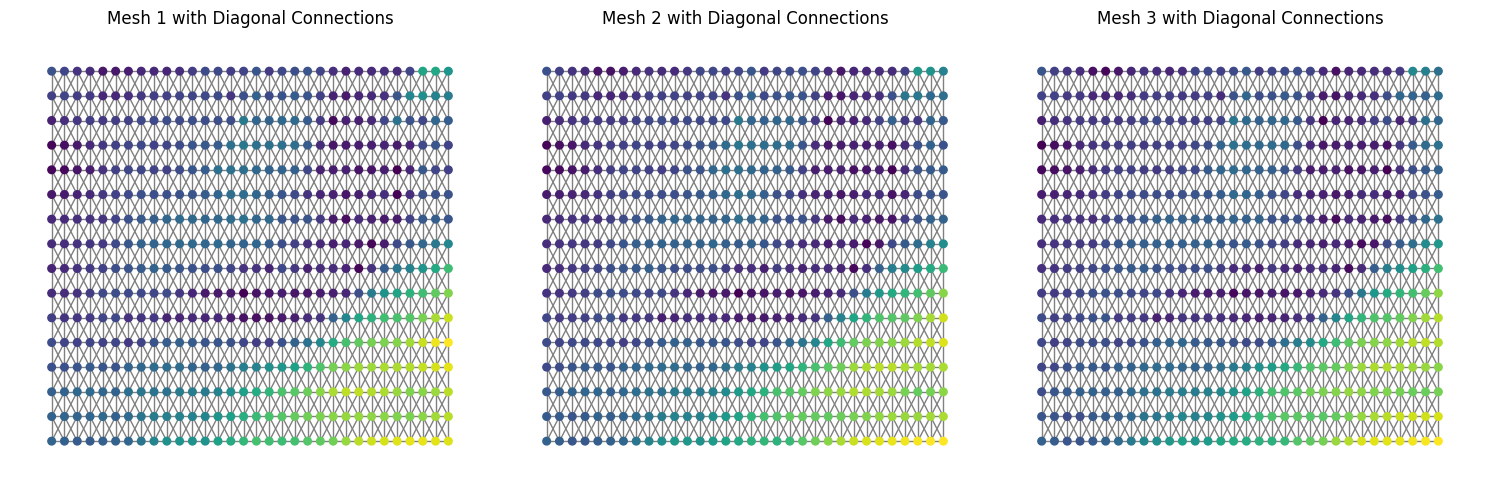

In [48]:
plot_mesh(meshes, positions_list)